In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

data_dir = "./data"

device = torch.device("cpu")

#if torch.backends.mps.is_available() and torch.backends.mps.is_built():
#    device = torch.device("mps")

if torch.cuda.is_available():
    device = torch.device("cuda")

print(f"Data resides in        : {data_dir}")
print(f"Training model on      : {str(device)}")

Data resides in        : ./data
Training model on      : cpu


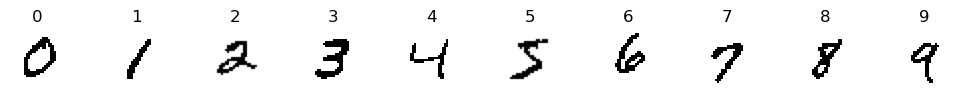

In [3]:
def print_samples(samples, elements_per_row=10, fig_width=10, cmap="binary"):
    num_digits = len(samples)
    num_rows = (num_digits + elements_per_row - 1) // elements_per_row

    plt.figure(figsize=(fig_width, fig_width / elements_per_row * num_rows))
    for idx, (label, image) in enumerate(samples):
        plt.subplot(num_rows, elements_per_row, idx + 1)
        plt.imshow(image.squeeze(), cmap=cmap)
        plt.title(label, fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,)),               # normalize to [0, 1]
    transforms.Lambda(lambda x: (x > 0.5).float())  # binarize
])

train_dataset = datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)

sample_list = [(label, next(image for image, lbl in train_dataset if lbl == label)) for label in range(10)]
print_samples(sample_list)

In [4]:
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden):
        super().__init__()
        self.n_visible = n_visible
        self.n_hidden = n_hidden

        self.W = nn.Parameter(torch.randn(n_visible, n_hidden) * 0.01)
        self.b = nn.Parameter(torch.zeros(n_visible))
        self.c = nn.Parameter(torch.zeros(n_hidden))

    def sample_hidden(self, v):
        h_probs = torch.sigmoid(v @ self.W + self.c)
        h_sample = torch.bernoulli(h_probs)
        return h_sample, h_probs

    def sample_visible(self, h):
        v_probs = torch.sigmoid(h @ self.W.t() + self.b)
        v_sample = torch.bernoulli(v_probs)
        return v_sample, v_probs

    def sample_gibbs(self, v0_sample, k=1):
        v = v0_sample
        for _ in range(k):
            h, _ = self.sample_hidden(v)
            v, _ = self.sample_visible(h)
        return v

    def free_energy(self, v):
        visible_term = v @ self.b
        hidden_term = nn.functional.softplus(v @ self.W + self.c).sum(dim=1)
        return -visible_term - hidden_term

In [15]:
def train_rbm(rbm, train_loader, num_epochs, k, optimizer, scheduler=None):
    rbm.train()

    persistent_v = torch.bernoulli(torch.rand(batch_size, rbm.n_visible)).to(device)

    metrics = {}
    for epoch in range(num_epochs):
        total_loss = 0.0
        for data, _ in train_loader:
            data = data.view(-1, rbm.n_visible).to(device)

            # positive phase
            h0, _ = rbm.sample_hidden(data)

            # negative phase using persistent fantasy particles
            v_k = rbm.sample_gibbs(persistent_v, k)
            persistent_v = v_k.detach()

            loss = rbm.free_energy(data).mean() - rbm.free_energy(v_k).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if scheduler is not None:
            scheduler.step()

        metrics[epoch] = { "free_energy_loss": total_loss / len(train_loader) }
        print(f"Epoch [{epoch+1}/{num_epochs}] - Free Energy Loss: {total_loss / len(train_loader):.4f}")

    return metrics



#### TRAINING

batch_size      = 128
visible_units   = 28*28
hidden_units    = 256
k               = 1
lr              = 1e-3
num_epochs      = 30
weight_decay    = 1e-5      # L2 regularization
lr_decay        = 0.95      # learning rate decay PER EPOCH


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

rbm = RBM(visible_units, hidden_units).to(device)

optimizer = optim.Adam(rbm.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay)

metrics = train_rbm(rbm, train_loader, num_epochs=num_epochs, k=k, optimizer=optimizer, scheduler=scheduler)

Epoch [1/30] - Free Energy Loss: -84.3085
Epoch [2/30] - Free Energy Loss: -26.6728
Epoch [3/30] - Free Energy Loss: -41.5138
Epoch [4/30] - Free Energy Loss: -38.7923
Epoch [5/30] - Free Energy Loss: -47.2793
Epoch [6/30] - Free Energy Loss: -31.5251
Epoch [7/30] - Free Energy Loss: -7.0025
Epoch [8/30] - Free Energy Loss: -6.0597
Epoch [9/30] - Free Energy Loss: -7.8981
Epoch [10/30] - Free Energy Loss: -10.0760
Epoch [11/30] - Free Energy Loss: -8.5726
Epoch [12/30] - Free Energy Loss: -10.1227
Epoch [13/30] - Free Energy Loss: -8.9575
Epoch [14/30] - Free Energy Loss: -6.9621
Epoch [15/30] - Free Energy Loss: -7.4468
Epoch [16/30] - Free Energy Loss: -6.9539
Epoch [17/30] - Free Energy Loss: -8.8082
Epoch [18/30] - Free Energy Loss: -9.4245
Epoch [19/30] - Free Energy Loss: -9.5596
Epoch [20/30] - Free Energy Loss: -9.4261
Epoch [21/30] - Free Energy Loss: -9.0629
Epoch [22/30] - Free Energy Loss: -10.0184
Epoch [23/30] - Free Energy Loss: -8.8451
Epoch [24/30] - Free Energy Loss: 

Text(0, 0.5, 'Free Energy Loss')

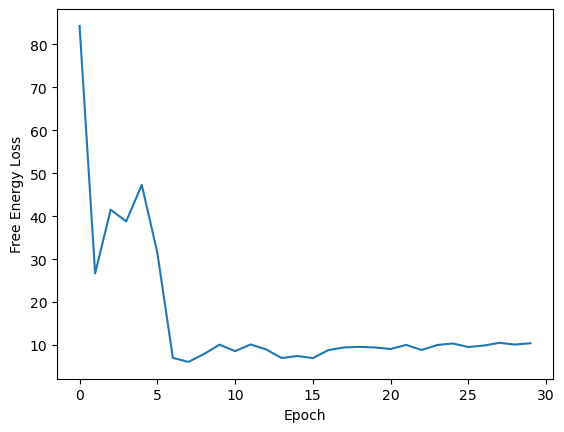

In [16]:
plt.plot([abs(metrics[epoch]['free_energy_loss']) for epoch in metrics])
plt.xlabel("Epoch")
plt.ylabel("Free Energy Loss")

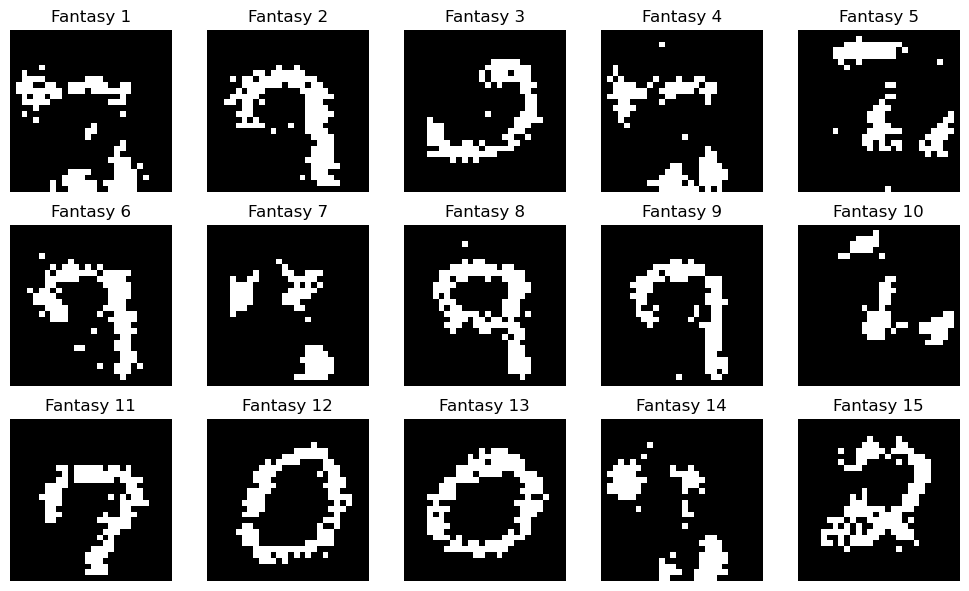

In [17]:
def sample_from_rbm(rbm, n_samples=16, n_steps=100):
    rbm.eval()

    v = torch.bernoulli(torch.rand(n_samples, rbm.n_visible)).to(device)
    with torch.no_grad():
        v = rbm.sample_gibbs(v, n_steps)
    return v.cpu().view(-1, 1, 28, 28)

#### GENERATION

fantasy_images = sample_from_rbm(rbm, n_samples=15, n_steps=200)
labeled_samples = [(f"Fantasy {idx+1}", img) for idx, img in enumerate(fantasy_images)]

print_samples(labeled_samples, elements_per_row=5, fig_width=10, cmap="gray")